# Plotting timeseries of Arctic ice speeds

* **Description**: Plots historical and future timeseries by month and region
* **Input data**: Processed rufmod and cesm2-le regional total netcdf files
* **Output data**: Timeseries plots in png format
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.stats import linregress,pearsonr, t, ttest_ind


## Read in the processed data

This reads in pre-processed regional ice sped for the Arctic.

In [2]:
# list the variables to load
var_in = 'sispeed'

In [3]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_7/fig_8_ice_motion/'

# set file names
fin_le = 'CESM2-LE_all_transient_regional_avg_'+var_in
fin_rufmod = 'rufmod_all_transient_regional_avg_'+var_in

In [4]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
len(month_names)

12

In [5]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_rufmod = xr.open_dataset(data_dir+fin_rufmod+'.nc',decode_times=True)

In [6]:
# double check that year/month is not shifted incorrectly
ds_le.coords['time.month']
ds_rufmod.coords['time.month']

<xarray.DataArray 'month' (time: 1032)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [7]:
# check what regions we have totals for
ds_le.region

# should match...
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

In [8]:
ds_le

<xarray.Dataset>
Dimensions:          (member_id: 50, time: 1032, region: 11)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region           (region) object 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'
Data variables:
    regional_totals  (member_id, time, region) float64 ...
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  ice speed

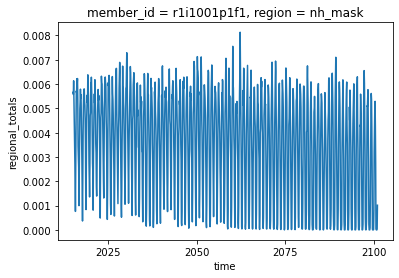

In [9]:
# just check the data to be sure it's working
ds_le['regional_totals'].sel(region='nh_mask',member_id='r1i1001p1f1').plot()

In [10]:
ds_rufmod

<xarray.Dataset>
Dimensions:          (member_id: 5, time: 1032, region: 11)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) int64 0 1 2 3 4
  * region           (region) object 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'
Data variables:
    regional_totals  (member_id, time, region) float64 ...
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  ice speed

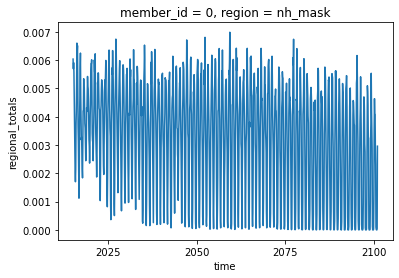

In [11]:
# just check the data to be sure it's working
ds_rufmod['regional_totals'].sel(region='nh_mask',member_id=0).plot()

In [12]:
print(ds_le.units)
print(ds_le.longname)

total_le = ds_le['regional_totals']
total_rufmod = ds_rufmod['regional_totals']

m/s
ice speed


In [13]:
# convert to cm/s
total_le = total_le*100.
total_rufmod = total_rufmod*100.
ds_le['units'] = 'cm/s'

### Seasonal means

In [14]:
season_names = ['MAR']
season_full = ['March']

In [15]:
# set x arrays against which to plot
xarr_le = total_le.coords['time.year'][(total_le.coords['time.month']==1)]
xarr_rufmod = total_rufmod.coords['time.year'][(total_rufmod.coords['time.month']==1)]

In [16]:
xarr_le

<xarray.DataArray 'year' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-01-16 12:00:00

In [17]:
# Loop through seasons - CESM2-LE

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(total_le.member_id),len(ds_le.region)])

for ss in season_names:
    print(ss)
    if ss == 'MAR':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'MAR':
        temp1 = total_le.isel(time=total_le.time.dt.month.isin([3]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        seas_array_le[s_count,y_count,:,:] = temp2.mean(dim='time')

MAR


In [18]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(total_rufmod.member_id),len(ds_rufmod.region)])

for ss in season_names:
    print(ss)
    if ss == 'MAR':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'MAR':
        temp1 = total_rufmod.isel(time=total_rufmod.time.dt.month.isin([3]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        seas_array_rufmod[s_count,y_count,:,:] = temp2.mean(dim='time')

MAR


In [19]:
print(seas_array_le.shape)
print(seas_array_rufmod.shape)

(1, 86, 50, 11)
(1, 86, 5, 11)


In [20]:
# convert the numpy array to a xarray for easier plotting
seas_le = xr.DataArray(seas_array_le,dims=('season','year','member_id','region'))
seas_rufmod = xr.DataArray(seas_array_rufmod,dims=('season','year','member_id','region'))

## Calculate ensemble means and bootstrapped means

Bootstrap the CESM2-LE (N=50) to find ensemble means using the same number of members as SMOOTH (N=5)

In [21]:
# calculate ensemble mean for SMOOTH and CESM2-LE over all members
seas_ens_mean_le = seas_le.mean(dim='member_id')
seas_ens_mean_rufmod = seas_rufmod.mean(dim='member_id')

In [22]:
# assign coordinates
seas_ens_mean_le['season'] = season_names
seas_ens_mean_le['year'] = xarr_le.values
seas_ens_mean_le['region'] = total_le['region']

seas_ens_mean_rufmod['season'] = season_names
seas_ens_mean_rufmod['year'] = xarr_le.values
seas_ens_mean_rufmod['region'] = total_rufmod['region']


In [23]:
# calculate statistical significance
sigval = 0.05

# calculate statistical significance
tval,pval = ttest_ind(seas_le,seas_rufmod,axis=2,equal_var=False)
seas_ens_mean_le_sig = seas_ens_mean_le.where(pval <= sigval)
seas_ens_mean_rufmod_sig = seas_ens_mean_rufmod.where(pval <= sigval)

In [24]:
print(seas_ens_mean_le.shape)
print(seas_ens_mean_rufmod.shape)

(1, 86, 11)
(1, 86, 11)


In [25]:
# bootstrap the CESM2-LE 1000 times
n_bs=1000
seas_bs_array_le = np.zeros([len(season_names),len(xarr_le),len(ds_le.region),n_bs])

for ii in range(n_bs):
    # choose random ensemble member numbers
    mem1=np.random.choice(range(0,49))
    mem2=np.random.choice(range(0,49))
    mem3=np.random.choice(range(0,49))
    mem4=np.random.choice(range(0,49))
    mem5=np.random.choice(range(0,49)) 
    # now average those random ensembles
    temp = np.stack((seas_le.sel(member_id=mem1),seas_le.sel(member_id=mem2),seas_le.sel(member_id=mem3),
                     seas_le.sel(member_id=mem4),seas_le.sel(member_id=mem5)),axis=-1)
    seas_bs_array_le[:,:,:,ii]=np.mean(temp,axis=3)

In [26]:
# convert the numpy array to a xarray for easier plotting
seas_bs_le = xr.DataArray(seas_bs_array_le,dims=('season','year','region','bootstrap_num'))

In [27]:
out_tag = var_in
label = ds_le.longname
units = 'cm/s'# ds_le.units

### Plotting!

In [28]:
print(seas_bs_le.shape)
print(seas_ens_mean_rufmod.shape)

(1, 86, 11, 1000)
(1, 86, 11)


In [29]:
# set xarray dimensions so we can select just nh_mask
seas_bs_le['season'] = season_names
seas_bs_le['year'] = xarr_le.values
seas_bs_le['region'] = ds_le.region

seas_ens_mean_le['season'] = season_names
seas_ens_mean_le['year'] = xarr_le.values
seas_ens_mean_le['region'] = ds_le.region

seas_ens_mean_rufmod['season'] = season_names
seas_ens_mean_rufmod['year'] = xarr_rufmod.values
seas_ens_mean_rufmod['region'] = ds_rufmod.region

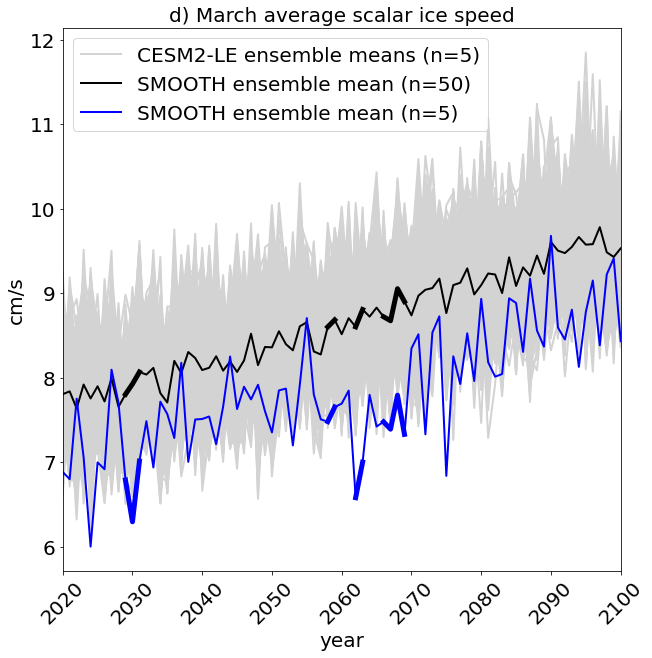

In [35]:
# Plot bootstrapped means
reg = 'ArcOc_mask'

# create figure
fig = plt.figure(figsize=(10,10))
# now loop through months to create subpanels
fout = 'fig_8_average_'+out_tag+'_march_'+reg

for ss in season_names:
    #print(ss)
    if ss == 'MAR':
        count = 0
    else: 
        count = count+1        
        
    # CESM2-LE: subset the data
    data_temp_le = seas_bs_le.sel(region=reg,season=ss)
    mean_le = seas_ens_mean_le.sel(region=reg,season=ss)
    mean_le_sig = seas_ens_mean_le_sig.sel(region=reg,season=ss)
    # rufmod: subset the data
    mean_rufmod = seas_ens_mean_rufmod.sel(region=reg,season=ss)
    mean_rufmod_sig = seas_ens_mean_rufmod_sig.sel(region=reg,season=ss)
    
    # Make subplot - note it's nrow x ncol x index (starting upper left)
    ax = fig.add_subplot(1,1,count+1)
    # plot the bootstrapped means
    for ii in range(n_bs):
        ax.plot(xarr_le,data_temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
    ax.plot(xarr_le,data_temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
    ax.plot(xarr_le,mean_le,label="SMOOTH ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
    ax.plot(xarr_rufmod,mean_rufmod,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
    # plot when ensemble means are significant
    ax.plot(xarr_le,mean_le_sig,color='black',linestyle='-',linewidth=5)
    ax.plot(xarr_rufmod,mean_rufmod_sig,color='blue',linestyle='-',linewidth=5) 
    
    plt.title('d) '+season_full[count]+' average scalar ice speed',fontsize=20)
    plt.xlabel('year',fontsize=20)
    plt.xticks(fontsize=20, rotation=45)
    plt.xlim([2020,2100])
    plt.ylabel(units,fontsize=20)
    plt.yticks(fontsize=20)
    #plt.ylim([0,0.14])
    plt.legend(loc='upper left', fontsize=20)
    
# Finalize figure and save
#fig.suptitle('Average scalar '+label+' over Arctic Ocean',fontsize=15, y=0.95)  
fig.subplots_adjust(wspace=0.15, hspace=0.2)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)